<a href="https://colab.research.google.com/github/bloyal/Deep-Learning-with-Python/blob/main/Deep_Learning_with_Python_Chapter_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11.2 Preparing text data

In [ ]:
# Creating a naive text vectorizer
import string

class Vectorizer:
  def standardize(self, text):
    text = text.lower()
    return "".join(char for char in text if char not in string.punctuation)

  def tokenize(self, text):
    text = self.standardize(text)
    return text.split()
  
  def make_vocabulary(self, dataset):
    self.vocabulary = {"": 0, "[UNK]": 1}
    for text in dataset:
      #text = self.standardize(text)  # I think this is redundant
      tokens = self.tokenize(text)
      for token in tokens:
        if token not in self.vocabulary:
          self.vocabulary[token] = len(self.vocabulary)
    self.inverse_vocabulary = dict(
        (v,k) for k, v in self.vocabulary.items()
    )
  
  def encode(self, text):
    #text = self.standardize(text) # I think this is redundant
    tokens = self.tokenize(text)
    return [self.vocabulary.get(token, 1) for token in tokens]
  
  def decode(self, int_sequence):
    return " ".join(
        self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence
    )

vectorizer = Vectorizer()
dataset = [
           "I write, erase, rewrite",
           "Erase again, and then",
           "A poppy blooms.",
]
vectorizer.make_vocabulary(dataset)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print("Encoded:", encoded_sentence)
decoded_sentence = vectorizer.decode(encoded_sentence)
print("Decoded:", decoded_sentence)

Encoded: [2, 3, 5, 7, 1, 5, 6]
Decoded: i write rewrite and [UNK] rewrite again


In [ ]:
vectorizer.standardize(test_sentence)

'i write rewrite and still rewrite again'

In [ ]:
vectorizer.tokenize(test_sentence)

['i', 'write', 'rewrite', 'and', 'still', 'rewrite', 'again']

In [ ]:
vectorizer.vocabulary

{'': 0,
 '[UNK]': 1,
 'a': 9,
 'again': 6,
 'and': 7,
 'blooms': 11,
 'erase': 4,
 'i': 2,
 'poppy': 10,
 'rewrite': 5,
 'then': 8,
 'write': 3}

In [ ]:
vectorizer.inverse_vocabulary

{0: '',
 1: '[UNK]',
 2: 'i',
 3: 'write',
 4: 'erase',
 5: 'rewrite',
 6: 'again',
 7: 'and',
 8: 'then',
 9: 'a',
 10: 'poppy',
 11: 'blooms'}

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorization = TextVectorization(output_mode="int")

In [ ]:
dataset = [
           "I write, erase, rewrite",
           "Erase again, and then",
           "A poppy blooms.",
]
text_vectorization.adapt(dataset)

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

tf.Tensor([ 7  3  5  9  1  5 10], shape=(7,), dtype=int64)
i write rewrite and [UNK] rewrite again


# 11.3 Two approaches for representing groups of words: sets and sequences

## 11.3.1 Preparing the IMDB movie reviews data

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  62.6M      0  0:00:01  0:00:01 --:--:-- 62.6M


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [ ]:
# Prepare a validation set in addition to test and train
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

In [ ]:
# Created batched Datasets of text files for training, validation, and testing

from tensorflow import keras
batch_size = 32

train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
# Listing 11.4 Displaying the shapes and dtypes of the first batch
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)  
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0] tf.Tensor(b"Corbin Bernsen gives a terrifically intense and riveting performance as Dr. Alan Feinstone, a wealthy and successful Beverly Hills dentist who's obsessed with perfection. When he discovers that his lovely blonde babe trophy wife has been cheating on him and the IRS start hounding him about tax problems, Feinstone cracks under the pressure and goes violently around the bend. Director Brian Yuzna, working from a suitably dark, witty and demented script by Stuart Gordon, Dennis Paoli, and Charles Finch, exposes the seething neurosis and psychosis bubbling underneath the squeaky clean well-manicured surface of respectable affluent rich America with deliciously malicious glee. Moreover, Yuzna further spices up the grisly goings on with a wickedly twisted sense of pitch black gallows humor. Bernsen positively shines as Dr. Feinstone; he expertly projects a truly unne

## 11.3.2 Processing words as a set: the bag-of-words approach

### Single words (unigrams) with binary encoding

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorization = TextVectorization(output_mode="int")

In [ ]:
# Listing 11.5 Preprocessing our datasets with a TextVectorization layer
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="binary",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
binary_1gram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
binary_1gram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

In [ ]:
#Listing 11.6 Inspecting the output of our binary unigram dataset
for inputs, targets in binary_1gram_train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
# Listing 11.7 A reusable model-building utility
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
# Listing 11.8 Training and testing the binary unigram model
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense (Dense)                (None, 16)                320016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 13s 15ms/step - loss: 0.4029 - accuracy: 0.8307 - val_loss: 0.2946 - val_accuracy: 0.8804
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2687 - accuracy: 0.9016 - val_loss: 0.2968 - val_accuracy: 0.8872
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2367 - accuracy: 0.9182 - val_loss: 0.3063 - val_accuracy: 0.8878
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2170 - accuracy: 0.9270 - val_loss: 0.3186 - val_accuracy: 0.8896
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2094 - accuracy: 0.9306 - val_loss: 0.3294 - val_accuracy: 0.8902
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2042 - accuracy: 0.9362 - val_loss: 0.3492 - val_accuracy: 0.8908
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2013 - accuracy: 0.9363 - val_loss: 0.3494 - val_accuracy: 0.8920
Epoc

### Bigrams with binary encoding

In [ ]:
# Listing 11.9 Configuring the TextVectorization layer to return bigrams
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="binary"
)


In [ ]:
# Listing 11.10 Training and testing the binary bigram model
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
binary_2gram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
binary_2gram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                320016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 18s 27ms/step - loss: 0.3758 - accuracy: 0.8458 - val_loss: 0.2666 - val_accuracy: 0.8974
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2486 - accuracy: 0.9140 - val_loss: 0.2711 - val_accuracy: 0.8996
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2136 - accuracy: 0.9303 - val_loss: 0.3042 - val_accuracy: 0.8948
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1960 - accuracy: 0.9384 - val_loss: 0.3282 - val_accuracy: 0.8962
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1867 - accuracy: 0.9412 - val_loss: 0.3412 - val_accuracy: 0.8950
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1875 - accuracy: 0.9438 - val_loss: 0.3571 - val_accuracy: 0.8902
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1905 - accuracy: 0.9455 - val_loss: 0.3642 - val_accuracy: 0.8918
Epoc

In [ ]:
### Bigrams with TF-IDF encoding

In [ ]:
# Listing 11.11 Configuring the TextVectorization layer to return token counts
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

In [ ]:
# Listing 11.12 Configuring the TextVectorization layer to return
# TF-IDF-weighted outputs
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf-idf",
)

In [ ]:
# Listing 11.13 Training and testing the TF-IDF bigram model
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
tfidf_2gram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
tfidf_2gram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                320016    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 15s 23ms/step - loss: 0.4767 - accuracy: 0.7879 - val_loss: 0.2985 - val_accuracy: 0.8822
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3403 - accuracy: 0.8635 - val_loss: 0.3041 - val_accuracy: 0.8792
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3189 - accuracy: 0.8730 - val_loss: 0.3143 - val_accuracy: 0.8748
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3031 - accuracy: 0.8748 - val_loss: 0.3269 - val_accuracy: 0.8794
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2978 - accuracy: 0.8757 - val_loss: 0.3519 - val_accuracy: 0.8604
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2843 - accuracy: 0.8810 - val_loss: 0.3658 - val_accuracy: 0.8446
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2787 - accuracy: 0.8860 - val_loss: 0.3689 - val_accuracy: 0.8570
Epoc

In [ ]:
# Exporting a model that processes raw strings (i.e. incorporating the text
# vectorization layer into the model)
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

86.76 percent positive


## 11.3.3 Processing words as a sequence: the Sequence Model approach

### A first practical example

In [ ]:
# Listing 11.14 Preparing integer sequence datasets
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_length = 600
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

In [ ]:
#Listing 11.5 A sequence model built on top of one-hot encoded vector sequences
import tensorflow as tf
from tensorflow.keras import layers
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot (TFOpLambda)      (None, None, 20000)       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                5128448   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Listing 11.16 Training a first basic sequence model
# Note: This takes forever because the one-hot encoded inputs are so large
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### Understanding word embeddings

#### Learning word embeddings with the `Embedding` layer

In [ ]:
# Listing 11.18 Model that uses an Embedding layer trained from scratch
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 57s 86ms/step - loss: 0.4543 - accuracy: 0.7958 - val_loss: 0

### Understanding padding and masking

In [ ]:
# Listing 1.19 Model that uses an Embedding layer trained from scratch, with masking enabledr
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 66s 95ms/step - loss: 0.3822 - accuracy: 0.8262 - val_loss: 0

### Using pretrained word embeddings

In [ ]:
# Download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-08-10 17:35:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-10 17:35:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-10 17:35:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!head glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [ ]:
# Listing 11.20 Parsing the GloVe word-embeddings file
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


### Loading the GloVe embeddings in the model

In [ ]:
# Listing 11.21 Preparing the GloVe word-embeddings matrix
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Load the pretrained embedding values into an Embedding layer
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

### Training a simple bidirectional LSTM on top of the GloVE embeddings

In [ ]:
# Listing 11.22 Model that uses a pretrained Embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 41s 55ms/step - loss: 0.5629 - accuracy: 0.7054 - val_lo

# 11.4 The Transformer architecture (Dum dum dum)

In [ ]:
# Listing 11.23 Transformer encoder implemented as a subclassed Layer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
# Listing 11.24 Text classification model that combines the Transformer encoder and a pooling layer
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         5120000   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 256)         543776    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,664,033
Trainable params: 5,664,033
Non-trainable params: 0
___________________________________________________

In [ ]:
# Listing 11.25 Training and evaluating the Transformer encoder based model
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 66s 95ms/step - loss: 0.4871 - accuracy: 0.7717 - val_loss: 0.3246 - val_accuracy: 0.8578
Epoch 2/20
625/625 [==============================] - 58s 93ms/step - loss: 0.3159 - accuracy: 0.8672 - val_loss: 0.2781 - val_accuracy: 0.8854
Epoch 3/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2452 - accuracy: 0.8995 - val_loss: 0.2780 - val_accuracy: 0.8840
Epoch 4/20
625/625 [==============================] - 59s 94ms/step - loss: 0.1915 - accuracy: 0.9251 - val_loss: 0.2872 - val_accuracy: 0.8836
Epoch 5/20
625/625 [==============================] - 59s 94ms/step - loss: 0.1563 - accuracy: 0.9402 - val_loss: 0.2941 - val_accuracy: 0.8846
Epoch 6/20
625/625 [==============================] - 58s 93ms/step - loss: 0.1293 - accuracy: 0.9525 - val_loss: 0.3410 - val_accuracy: 0.8876
Epoch 7/20
625/625 [==============================] - 58s 93ms/step - loss: 0.1117 - accuracy: 0.9590 - val_loss: 0.4624 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# Listing 11.26 Implementing positional embedding as a subclassed layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
### Putting it all together: A text-classification Transformer
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# 11.5 Beyond text classification: sequence-to-sequence learning

In [6]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2021-08-11 18:20:11--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.006s  

2021-08-11 18:20:11 (393 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [7]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [3]:
text_pairs[10000:10010]

[('Do you like fish?', '[start] ¿Te gusta el pescado? [end]'),
 ('Do you like golf?', '[start] ¿Te gusta el golf? [end]'),
 ('Do you like rain?', '[start] ¿Te gusta la lluvia? [end]'),
 ('Do you like snow?', '[start] ¿Te gusta la nieve? [end]'),
 ('Do you like that?', '[start] ¿Te gusta eso? [end]'),
 ('Do you like them?', '[start] ¿Te gustan? [end]'),
 ('Do you like this?', '[start] ¿Te gusta esto? [end]'),
 ('Do you live here?', '[start] ¿Vives aquí? [end]'),
 ('Do you live here?', '[start] ¿Usted vive aquí? [end]'),
 ('Do you live here?', '[start] ¿Vivís aquí? [end]')]

In [8]:
# Shuffle training data and split into training, val, and test sets

import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [9]:
print(f"Train: {len(train_pairs)} Val: {len(val_pairs)} Test: {len(test_pairs)}")

Train: 83276 Val: 17844 Test: 17844


In [10]:
# Listing 11.28 Vectorizing the English and Spanish text pairs
from keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

In [11]:
print(train_english_texts[0])
print(source_vectorization.get_vocabulary()[:10])
print(target_vectorization.get_vocabulary()[:10])

Tom is going to be punished for what he did.
['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']
['', '[UNK]', '[start]', '[end]', 'de', 'que', 'a', 'no', 'tom', 'la']


In [12]:
# Listing 11.29 Preparing training and validation datasets for the translation task
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [13]:
 for inputs, targets in train_ds.take(1):
   print(f"inputs['english'].shape: {inputs['english'].shape}")
   print(f"inputs['english'][0]: {inputs['english'][0]}")
   print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
   print(f"inputs['spanish'][0]: {inputs['spanish'][0]}")
   print(f"targets.shape: {targets.shape}")
   print(f"targets[0]: {targets[0]}")

inputs['english'].shape: (64, 20)
inputs['english'][0]: [  3 239 105   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
inputs['spanish'].shape: (64, 20)
inputs['spanish'][0]: [   2 1349   57    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [1349   57    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## 11.5.2 Sequence-to-sequence learning with RNNs

In [14]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

In [15]:
# Listing 11.30 GRU-based encoder
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

In [16]:
# Listing 11.31 GRU-based decoder and the end-to-end model
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

In [17]:
# Listing 11.32 Training our recurrent sequence-to-sequence model
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
1302/1302 [==============================] - 196s 138ms/step - loss: 1.6551 - accuracy: 0.4134 - val_loss: 1.3440 - val_accuracy: 0.4998
Epoch 2/3
1302/1302 [==============================] - 177s 136ms/step - loss: 1.3370 - accuracy: 0.5228 - val_loss: 1.1844 - val_accuracy: 0.5635
Epoch 3/3
1302/1302 [==============================] - 176s 135ms/step - loss: 1.1940 - accuracy: 0.5722 - val_loss: 1.0983 - val_accuracy: 0.5943


In [18]:
# Listing 11.33 Translating new sentences with our RNN encoder and decoder
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom laughs at his own jokes.
[start] tom se quedó en sus manos [end]
-
Did you hear it too?
[start] lo has hecho [end]
-
Tom's awake.
[start] tom está [UNK] [end]
-
Can you do that again?
[start] puedes hacer eso de nuevo [end]
-
They became man and wife.
[start] ellos se [UNK] y a los perros [end]
-
There's someone outside.
[start] hay alguien ahí [end]
-
Life has become very hard.
[start] la vida se ha hecho muy bien [end]
-
I can speak Chinese, but I can't read it.
[start] yo puedo hablar francés pero no puedo nada [end]
-
Her friend is a singer.
[start] su hijo es un estudiante [end]
-
Life is short and time is swift.
[start] la vida es y se habla en el momento [end]
-
They went in opposite directions.
[start] ellos se fue en un lugar de [UNK] [end]
-
It might snow tonight.
[start] podría leer esta noche [end]
-
She made the same mistake again.
[start] ella hizo el trabajo en el trabajo [end]
-
Helena is a secretary, right?
[start] el [UNK] es una lengua importante [end]
-
We are

In [20]:
seq2seq_rnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
english (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
spanish (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    5120000     english[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    5120000     spanish[0][0]                    
____________________________________________________________________________________________

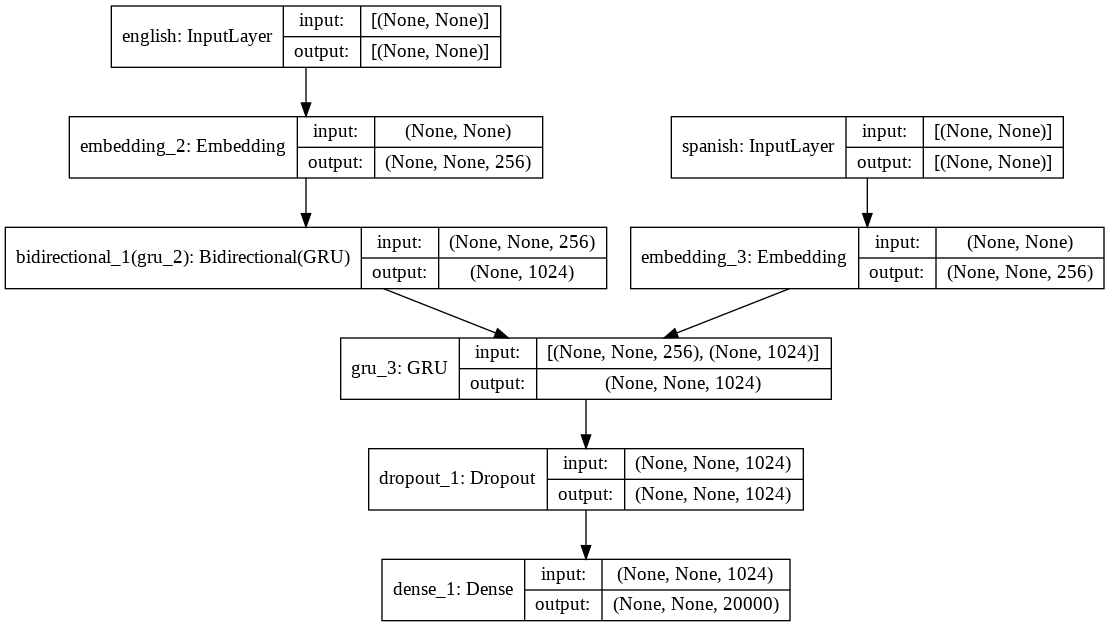

In [22]:
keras.utils.plot_model(seq2seq_rnn, show_shapes=True)

## Sequence-to-sequence learning with Transformer

In [23]:
# Listing 11.26 Implementing positional embedding as a subclassed layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
  
# Listing 11.23 Transformer encoder implemented as a subclassed Layer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

In [25]:
# Listing 11.35 The Transformer Decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)
    
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [26]:
# Listing 11.38 End-to-End Transformer
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [27]:
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
english (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
spanish (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    5273600     english[0][0]                    
__________________________________________________________________________________________________
positional_embedding_1 (Positio (None, None, 256)    5273600     spanish[0][0]                    
____________________________________________________________________________________________

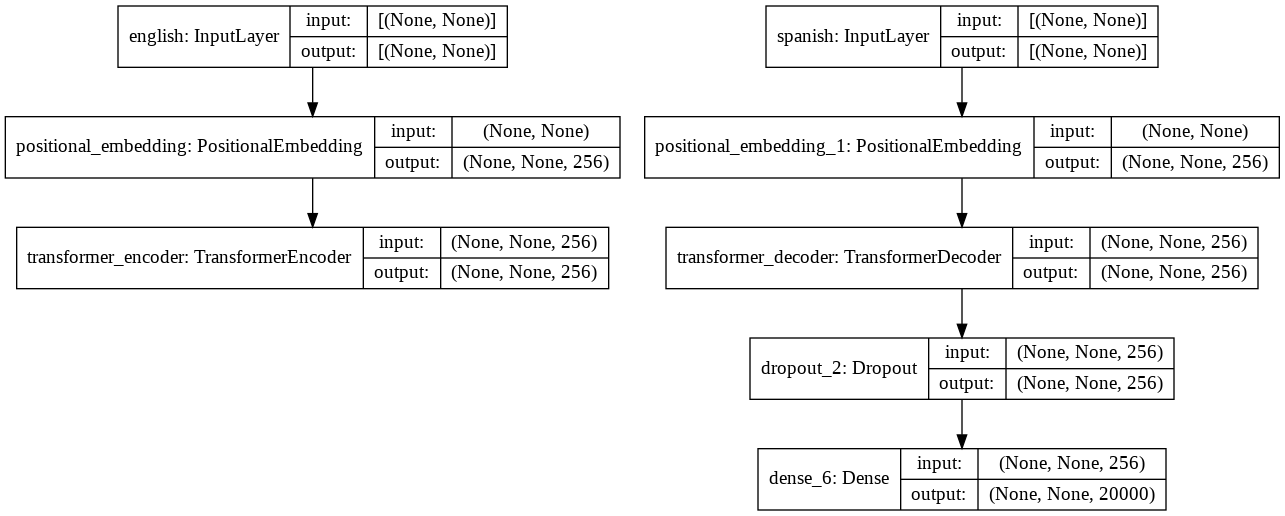

In [28]:
keras.utils.plot_model(transformer, show_shapes=True)

In [29]:
# Listing 11.39 Training the seq-to-seq Transformer
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3
1302/1302 [==============================] - 149s 111ms/step - loss: 1.6912 - accuracy: 0.4158 - val_loss: 1.3338 - val_accuracy: 0.5113
Epoch 2/3
1302/1302 [==============================] - 143s 110ms/step - loss: 1.3505 - accuracy: 0.5319 - val_loss: 1.1759 - val_accuracy: 0.5664
Epoch 3/3
1302/1302 [==============================] - 144s 110ms/step - loss: 1.2048 - accuracy: 0.5786 - val_loss: 1.1020 - val_accuracy: 0.5956


In [31]:
# Listing 11.40 Translating new sentences with Transformer model
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
He had the nerve to say that.
[start] Él tenía la decir que decir [end]
-
Tom saw Mary eating by herself at a table near the window.
[start] tom vio a mary solo en la mesa ventana de la ventana [end]
-
Why are you so paranoid?
[start] por qué son tan míos [end]
-
I smell something awful.
[start] yo odio algo importante [end]
-
The door opened.
[start] la puerta abrió la puerta [end]
-
Tom got a flu shot.
[start] tom se hizo una cita [end]
-
They went to the United States last month.
[start] ellos fueron al estados unidos el día de los mes [end]
-
Tom is happy again.
[start] tom está feliz de nuevo [end]
-
I'm fixing the radio I found on my way home.
[start] estoy buscando la radio que me perdí el lugar de casa [end]
-
Tom has friends all over the world.
[start] tom tiene todos los amigos [end]
-
Tom gave Mary a hug and a kiss.
[start] tom le dio un poco de mary y un mensaje [end]
-
I'm behind him.
[start] estoy seguro de él [end]
-
Our request was approved.
[start] nuestro país fue [